In [20]:
import carla
import pickle
import numpy as np
import os


# 连接到CARLA服务器
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
map_name = 'Town05'
world = client.load_world(map_name)
world_map = world.get_map()
waypoints = world_map.generate_waypoints(2.0)

traffic_lights = world.get_actors().filter('traffic.traffic_light')

import pandas as pd
data_list = []

for waypoint in world_map.generate_waypoints(1.0):
    x = waypoint.transform.location.x
    y = waypoint.transform.location.y
    road_id = waypoint.road_id
    lane_id = waypoint.lane_id
    s = waypoint.s
    data_list.append([x, y, road_id, lane_id, s])

map_df = pd.DataFrame(data_list, columns=['x', 'y', 'road_id', 'lane_id', 's'])


# 获取十字路口
junctions = [waypoint for waypoint in waypoints if waypoint.is_junction]

# 分组每个路口的路点
junctions_and_waypoints = {}
for waypoint in waypoints:
    for junction in junctions:
        if waypoint.is_junction and waypoint.junction_id == junction.junction_id:
            if junction not in junctions_and_waypoints:
                junctions_and_waypoints[junction] = []
            junctions_and_waypoints[junction].append(waypoint)

for junction, waypoints in junctions_and_waypoints.items():
    # 绘制十字路口前50米的路点
    previous_waypoint = junction.previous(50)[0]

    # 获取车道
    lane_id, road_id = previous_waypoint.lane_id, previous_waypoint.road_id
    road_data = map_df[(map_df['lane_id'] == lane_id) & (map_df['road_id'] == road_id)]
    first_row = road_data.iloc[0]
    world.debug.draw_point(carla.Location(x=first_row['x'], y=first_row['y']), size=0.1, color=carla.Color(255, 0, 0), life_time=100)
    stop_line_y = first_row['y'] 

    lane_width = previous_waypoint.lane_width
    left = carla.Location(x=first_row['x'] + lane_width * 1.5, y=stop_line_y)
    right = carla.Location(x=first_row['x'] - lane_width * 0.5, y=stop_line_y)

    world.debug.draw_string(left, 'Left', draw_shadow=False,
                            color=carla.Color(r=255, g=0, b=0), life_time=100)
    world.debug.draw_string(right, 'Right', draw_shadow=False,
                            color=carla.Color(r=255, g=0, b=0), life_time=100)
    break

32


(-2.135422515869141, 44.84387283325195, -5.063722610473633, 106.33817481994629)

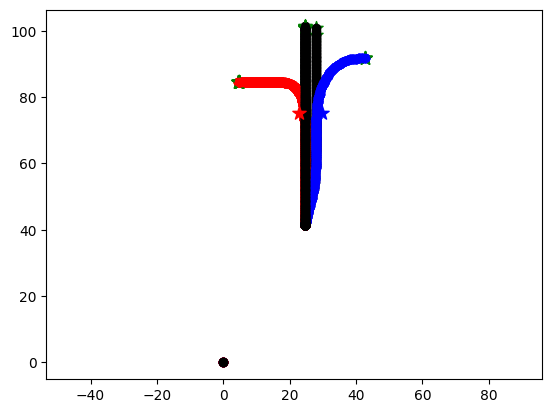

: 

In [37]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

trajectory_data = pickle.load(open('traj/vehicle_trajectory_20240108125034.pkl', "rb"))
print(len(trajectory_data))

a, b, c = 0, 0, 0
for i in range(len(trajectory_data)):
    traj = np.array(trajectory_data[i])
    
    if traj[-1][1] < stop_line_y + 1:
        continue
    data = []
    plt.scatter(traj[-1][0], traj[-1][1], c='g', s=100, marker='*')

    if traj[-1][0] < right.x:
        label = 0 # 左转
        plt.scatter(traj[:, 0], traj[:, 1], c='r')
        a += 1
    elif traj[-1][0] > left.x:
        label = 2 # 右转
        plt.scatter(traj[:, 0], traj[:, 1], c='b')
        b += 1
    else:
        label = 1 # 直行
        plt.scatter(traj[:, 0], traj[:, 1], c='k')
        c += 1

# plt.scatter(first_row['x'], first_row['y'], c='g', s=100, marker='*')
plt.scatter(left.x, left.y, c='b', s=100, marker='*')
plt.scatter(right.x, right.y, c='r', s=100, marker='*')


plt.axis('equal')

In [35]:
print(a, b, c)

12 4 11
